## Section 1 Data Preparation

In [108]:
import pandas as pd
df = pd.read_csv('purchase_credit_card.csv') #, encoding = "ISO-8859-1")    
df.head(5)  

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"GROCERY STORES,AND SUPERMARKETS"
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."


In [109]:
# check dimensions of the dataset, dataset has 442,458 rows and 11 columns 
print(df.shape)
print(df.columns) # check column names
df.describe() # Get the Simple Summary Statistics 

(442458, 11)
Index(['Year-Month', 'Agency Number', 'Agency Name', 'Cardholder Last Name',
       'Cardholder First Initial', 'Description', 'Amount', 'Vendor',
       'Transaction Date', 'Posted Date', 'Merchant Category Code (MCC)'],
      dtype='object')


,Year-Month,Agency Number,Amount
count,442458.000000,442458.000000,4.424580e+05
mean,201357.284375,42785.860353,4.249912e+02
std,47.107417,33378.461293,5.266509e+03
min,201307.000000,1000.000000,-4.286304e+04
25%,201309.000000,1000.000000,3.091000e+01
50%,201401.000000,47700.000000,1.048900e+02
75%,201404.000000,76000.000000,3.450000e+02
max,201406.000000,98000.000000,1.903858e+06


In [110]:
# change column names 
df.columns = ['Year_Month', 'Agency_Number', 'Agency_Name', 'Cardholder_Last_Name',
      'Cardholder_First_Initial', 'Description', 'Amount', 'Vendor', 'Transaction_Date',
      'Posted_Date', 'Merchant_Category']

### 1.1 Create data fields

In [111]:
#Creating separate Year and Month columns for future feature engineering
# Converting Transaction_Date and Posted_date from Python Object data type to datetime
df['Transaction_Date']=pd.to_datetime(df['Transaction_Date'])
df['Posted_Date']=pd.to_datetime(df['Posted_Date'])

df['Year_Month'].dtype
df['Year_Month']=pd.to_datetime(df['Year_Month'], format='%Y%m')
df['Year'] = df['Year_Month'].dt.year
df['Month'] = df['Year_Month'].dt.month
#Creating 'Week_Number' from 'Transaction_Date'
df['Week_Number'] = df['Transaction_Date'].dt.isocalendar().week

#Creating 'Day_of_Week' from 'Transaction_Date'
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['Day_of_Week'] = df['Transaction_Date'].dt.dayofweek.map(dayOfWeek)

df['Day_of_Week'].value_counts()

Wednesday    89644
Thursday     87537
Tuesday      86919
Friday       79917
Monday       61809
Saturday     26307
Sunday       10325
Name: Day_of_Week, dtype: int64

## Section 2 Initial observations

From the graph below, we can see University of OKLAHOMA has the most transactions, followed by Univ. of Okla health science center

<AxesSubplot:xlabel='Count', ylabel='Agency_Name'>

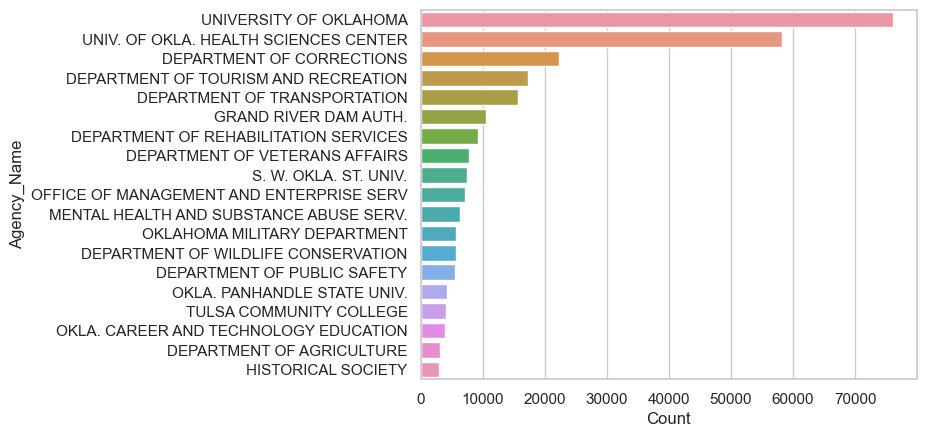

In [112]:
import numpy as np
import plotly
import pandas as pd
import plotly.express as px

# Summarize the count statistics by agency_name in df_count
df_count = df['Agency_Name'].value_counts()
df_count = pd.DataFrame(df_count).reset_index()
df_count.columns = ['Agency_Name','Count']

fig = px.bar(df_count, x='Agency_Name', y='Count', color = 'Agency_Name', width=1000, height=400)
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.barplot(y="Agency_Name", x="Count", data=df_count[1:20])

## Section 3 Feature Engineering

### 3.1 Feature 1: The ratio to average amount

In [113]:
# create average spending group by agency and merchant category 
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category'])['Amount'].mean()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['AVG_amount']
stat_by_agency

AVG_amount
Agency_Name                     Merchant_Category                                     
ARDMORE HIGHER EDUCATION CENTER BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED  115.120000
                                CATALOG MERCHANTS                           -53.344286
                                COMPUTER NETWORK/INFORMATION SERVICES        18.340000
                                DRUG STORES AND PHARMACIES                  153.450000
                                GROCERY STORES,AND SUPERMARKETS              74.525455
...                                                                                ...
`DEPARTMENT OF EDUCATION        TELECOMMUNICATION SERVICES                  118.054000
                                TRAVEL AGENCIES                              24.253731
                                TROPICANA RESORT AND CASINO                 481.600000
                                UNITED AIRLINES                             310.547368
                                WYNDHAM HOTELS                               93.282857

[8427 rows x 1 columns]

In [114]:
# add the new feature average spending to the dataset 
df1 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df1['agency_merchant_avg_ratio_amount'] = np.where(df1['AVG_amount']==0,0, df1['Amount'] / df1['AVG_amount'])
df1['agency_merchant_avg_ratio_amount'].describe()

count    442458.000000
mean          0.999724
std           7.225363
min       -2735.680000
25%           0.177145
50%           0.515301
75%           1.102916
max        2735.680000
Name: agency_merchant_avg_ratio_amount, dtype: float64

### Thought process:
1. The above percentile motivates me to cut by percentile for plotting
2. Do you notice some transactions can be 2 times of the average. Could they be anomalies?

In [115]:
# cut by percentile for plotting
var = 'agency_merchant_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df1[binned_var] = pd.qcut(df1[var], percentile)
df1[['agency_merchant_avg_ratio_amount_D']]

,agency_merchant_avg_ratio_amount_D
0,"(1.298, 3.515]"
1,"(0.515, 1.298]"
2,"(0.133, 0.515]"
3,"(1.298, 3.515]"
4,"(0.133, 0.515]"
...,...
442453,"(0.515, 1.298]"
442454,"(0.133, 0.515]"
442455,"(0.0212, 0.133]"
442456,"(8.71, 2735.68]"


<AxesSubplot:xlabel='agency_merchant_avg_ratio_amount_D', ylabel='count'>

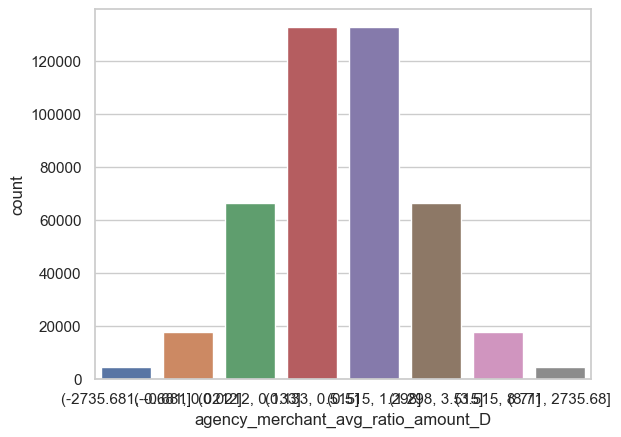

In [116]:
# check percentile distribution
sns.countplot(x="agency_merchant_avg_ratio_amount_D", data=df1)

### Thought process:
1. It will be ideal if the x label does not overlap with each other.
2. Try to rotate it.

[Text(0, 0, '(-2735.681, -0.681]'),
 Text(1, 0, '(-0.681, 0.0212]'),
 Text(2, 0, '(0.0212, 0.133]'),
 Text(3, 0, '(0.133, 0.515]'),
 Text(4, 0, '(0.515, 1.298]'),
 Text(5, 0, '(1.298, 3.515]'),
 Text(6, 0, '(3.515, 8.71]'),
 Text(7, 0, '(8.71, 2735.68]')]

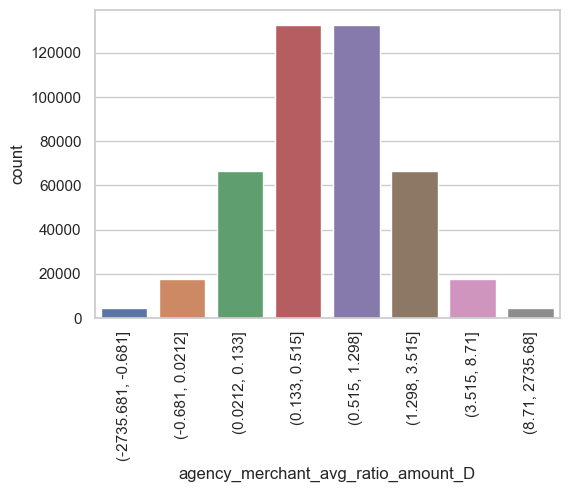

In [117]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_avg_ratio_amount_D", data=df1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

### Thought process:
1. Now we have identified extreme spending compared to the same merchant category.
2. Take a look of them.

In [118]:
df1[df1['agency_merchant_avg_ratio_amount']>2].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,AVG_amount,agency_merchant_avg_ratio_amount,agency_merchant_avg_ratio_amount_D
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,2013,7,31,Tuesday,427.634060,2.081219,"(1.298, 3.515]"
16,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mohiuddin,I,GENERAL PURCHASE,2425.00,WESTERN EQUIPMENT ALVA,2013-07-29,2013-07-31,HARDWARE STORES,2013,7,31,Monday,170.060436,14.259636,"(8.71, 2735.68]"
17,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mohiuddin,I,GENERAL PURCHASE,2425.00,WESTERN EQUIPMENT ALVA,2013-07-29,2013-07-31,HARDWARE STORES,2013,7,31,Monday,170.060436,14.259636,"(8.71, 2735.68]"
33,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Gerlt,T,GENERAL PURCHASE,3582.00,TELVENT,2013-07-26,2013-07-29,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,2013,7,30,Friday,392.641168,9.122833,"(8.71, 2735.68]"
35,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,GODSEY,R,GENERAL PURCHASE,407.85,OPTIMUM ENERGY PROD,2013-07-26,2013-07-29,HARDWARE STORES,2013,7,30,Friday,170.060436,2.398265,"(1.298, 3.515]"


### 3.1 Feature 2: The ratio to the median amount

In [119]:
# create median spending group by agency and merchant category 
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category'])['Amount'].median() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['Median_amount']

In [120]:
# add the new feature median spending to the dataset 
df2 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df2['agency_merchant_median_ratio_amount'] = np.where(df2['Median_amount']==0,0, df2['Amount'] / df2['Median_amount'])
df2['agency_merchant_median_ratio_amount'].describe()

count    442458.000000
mean          4.952685
std        1078.581350
min       -1003.176471
25%           0.466090
50%           1.000000
75%           2.121102
max      528116.052705
Name: agency_merchant_median_ratio_amount, dtype: float64

In [121]:
# cut by percentile for plotting
var = 'agency_merchant_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df2[binned_var] = pd.qcut(df2[var],percentile)

[Text(0, 0, '(-1003.177, -1.121]'),
 Text(1, 0, '(-1.121, 0.0653]'),
 Text(2, 0, '(0.0653, 0.362]'),
 Text(3, 0, '(0.362, 1.0]'),
 Text(4, 0, '(1.0, 2.691]'),
 Text(5, 0, '(2.691, 9.283]'),
 Text(6, 0, '(9.283, 28.085]'),
 Text(7, 0, '(28.085, 528116.053]')]

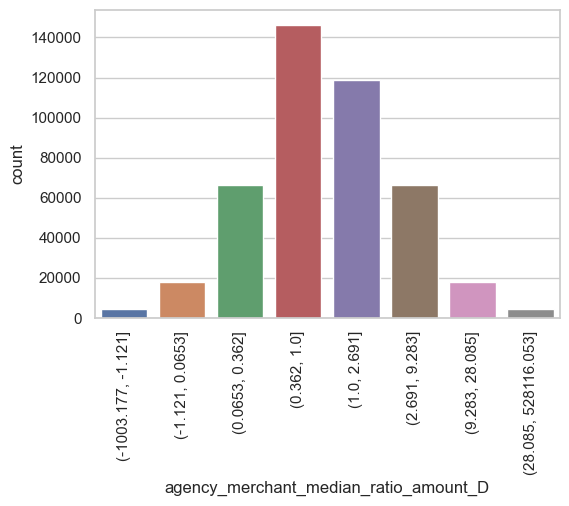

In [122]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_median_ratio_amount_D", data=df2)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [123]:
# Now we have identified extreme spending compared to the same merchant category.
df2[df2['agency_merchant_median_ratio_amount']>2].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,Median_amount,agency_merchant_median_ratio_amount,agency_merchant_median_ratio_amount_D
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,2013,7,31,Tuesday,250.000,3.560000,"(2.691, 9.283]"
3,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS",2013,7,31,Tuesday,32.485,2.967216,"(2.691, 9.283]"
5,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,GENERAL PURCHASE,394.28,KYOCERA DOCUMENT SOLUTION,2013-07-29,2013-07-31,"OFFICE, PHOTOGRAPHIC, PHOTOCOPY, AND MICROFILM...",2013,7,31,Monday,181.940,2.167088,"(1.0, 2.691]"
12,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,McLemore,A,GENERAL PURCHASE,572.27,GIDDINGS MACHINE CO.,2013-07-30,2013-07-31,"COMMERCIAL EQUIPMENT, NOT ELSEWHERE CLASSIFIED",2013,7,31,Tuesday,187.000,3.060267,"(2.691, 9.283]"
14,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Meints,K,GENERAL PURCHASE,445.00,OK DEPT OF VO-TECH ED,2013-07-30,2013-07-31,GOVERNMENT SERVICES--NOT ELSEWHERE CLASSIFIED,2013,7,31,Tuesday,91.500,4.863388,"(2.691, 9.283]"


### 3.3 Feature 3: The ratio to average monthly amount

1. From previous first feature we chose, we formulate structures based on agency and merchant category
2. Furthermore, we can dive deeper in the same structure but more detailed in time dimension by looking into variable month

In [124]:
# extract month from datetime 'Year_Month' and assign to new column
df['Month'] = df['Year_Month'].dt.month

# create average monthly spending group by agency, merchant category and month
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category', 'Month'])['Amount'].mean()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['monthly_AVG_amount']
stat_by_agency

monthly_AVG_amount
Agency_Name                     Merchant_Category                          Month                    
ARDMORE HIGHER EDUCATION CENTER BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED 11             115.120000
                                CATALOG MERCHANTS                          7             -637.750000
                                                                           8              669.080000
                                                                           9             -334.540000
                                                                           10             334.540000
...                                                                                              ...
`DEPARTMENT OF EDUCATION        UNITED AIRLINES                            9              260.450000
                                                                           10             523.800000
                                                                           12             199.633333
                                WYNDHAM HOTELS                             1                0.000000
                                                                           12             130.596000

[39888 rows x 1 columns]

In [125]:
# add the new feature average spending to the dataset 
df3 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category', 'Month'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df3['agency_merchant_monthly_avg_ratio_amount'] = np.where(df3['monthly_AVG_amount']==0,0, df3['Amount'] / df3['monthly_AVG_amount'])
df3['agency_merchant_monthly_avg_ratio_amount'].describe()

count    4.424580e+05
mean     9.991488e-01
std      5.961952e+13
min     -2.447706e+16
25%      2.017647e-01
50%      5.984763e-01
75%      1.125213e+00
max      3.059633e+16
Name: agency_merchant_monthly_avg_ratio_amount, dtype: float64

In [126]:
# cut by percentile for plotting
var = 'agency_merchant_monthly_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df3[binned_var] = pd.qcut(df3[var],percentile)
df3[['agency_merchant_monthly_avg_ratio_amount_D']]

,agency_merchant_monthly_avg_ratio_amount_D
0,"(1.34, 3.417]"
1,"(0.598, 1.34]"
2,"(0.151, 0.598]"
3,"(1.34, 3.417]"
4,"(0.151, 0.598]"
...,...
442453,"(0.151, 0.598]"
442454,"(0.151, 0.598]"
442455,"(0.0239, 0.151]"
442456,"(8.05, 3.0596329968448308e+16]"


[Text(0, 0, '(-2.4477063974758644e+16, -0.734]'),
 Text(1, 0, '(-0.734, 0.0239]'),
 Text(2, 0, '(0.0239, 0.151]'),
 Text(3, 0, '(0.151, 0.598]'),
 Text(4, 0, '(0.598, 1.34]'),
 Text(5, 0, '(1.34, 3.417]'),
 Text(6, 0, '(3.417, 8.05]'),
 Text(7, 0, '(8.05, 3.0596329968448308e+16]')]

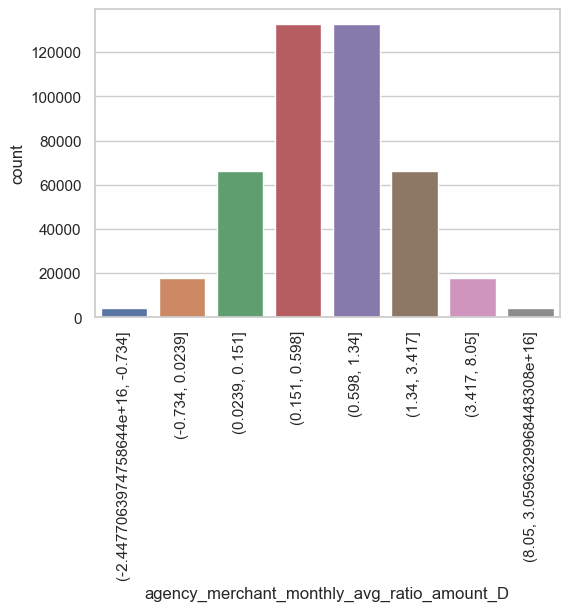

In [127]:
#sns.countplot(x="agency_merchant_monthly_avg_ratio_amount_D", data=df3)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_monthly_avg_ratio_amount_D", data=df3)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [128]:
df3[df3['agency_merchant_monthly_avg_ratio_amount']>2].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,monthly_AVG_amount,agency_merchant_monthly_avg_ratio_amount,agency_merchant_monthly_avg_ratio_amount_D
16,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mohiuddin,I,GENERAL PURCHASE,2425.0,WESTERN EQUIPMENT ALVA,2013-07-29,2013-07-31,HARDWARE STORES,2013,7,31,Monday,235.679053,10.289417,"(8.05, 3.0596329968448308e+16]"
17,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mohiuddin,I,GENERAL PURCHASE,2425.0,WESTERN EQUIPMENT ALVA,2013-07-29,2013-07-31,HARDWARE STORES,2013,7,31,Monday,235.679053,10.289417,"(8.05, 3.0596329968448308e+16]"
33,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Gerlt,T,GENERAL PURCHASE,3582.0,TELVENT,2013-07-26,2013-07-29,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,2013,7,30,Friday,568.982548,6.295448,"(3.417, 8.05]"
47,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,DALCOUR,K,GENERAL PURCHASE,1312.2,NATURAL WATER COMPANY LLC,2013-07-24,2013-07-26,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,2013,7,30,Wednesday,568.982548,2.306222,"(1.34, 3.417]"
49,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,DALCOUR,K,GENERAL PURCHASE,914.0,AUTO-CHLOR SERVICES INC,2013-07-24,2013-07-26,CATALOG MERCHANTS,2013,7,30,Wednesday,450.829655,2.027373,"(1.34, 3.417]"


### 3.4 Feature 4: The ratio to the monthly median amount

1. From previous second feature we chose, we formulated structures based on agency and merchant category
2. Furthermore, we can dive deeper in the same structure but more detailed in time dimension by looking into variable month

In [129]:
# create median spending group by agency, merchant and month category 
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category', 'Month'])['Amount'].median() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['monthly_Median_amount']

In [130]:
# add the new feature average spending to the dataset 
df4 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category', 'Month'])
# Feature 4: ratio of amount spending and avergae spending by merchant category 
df4['agency_merchant_monthly_median_ratio_amount'] = np.where(df4['monthly_Median_amount']==0,0, df4['Amount'] / df4['monthly_Median_amount'])
df4['agency_merchant_monthly_median_ratio_amount'].describe()

count    442458.000000
mean          5.010047
std        1195.766096
min      -29642.000000
25%           0.500000
50%           1.000000
75%           1.912717
max      598420.505983
Name: agency_merchant_monthly_median_ratio_amount, dtype: float64

In [131]:
# cut by percentile for plotting
var = 'agency_merchant_monthly_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df4[binned_var] = pd.qcut(df4[var],percentile)

[Text(0, 0, '(-29642.001, -1.103]'),
 Text(1, 0, '(-1.103, 0.0687]'),
 Text(2, 0, '(0.0687, 0.389]'),
 Text(3, 0, '(0.389, 1.0]'),
 Text(4, 0, '(1.0, 2.425]'),
 Text(5, 0, '(2.425, 8.71]'),
 Text(6, 0, '(8.71, 27.182]'),
 Text(7, 0, '(27.182, 598420.506]')]

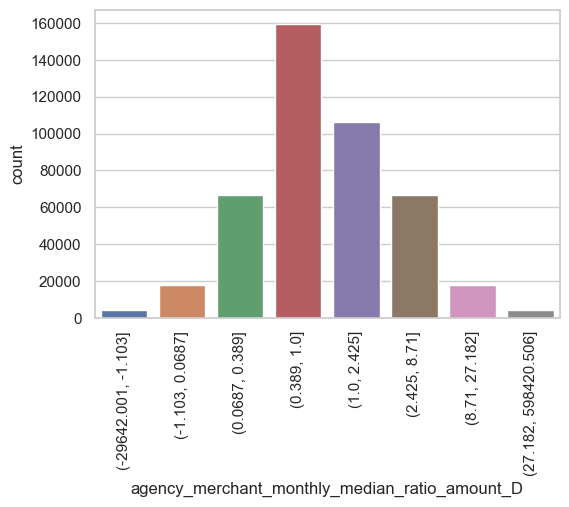

In [132]:
#sns.countplot(x="agency_merchant_monthly_median_ratio_amount_D", data=df3)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_monthly_median_ratio_amount_D", data=df4)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [133]:
df4[df4['agency_merchant_monthly_median_ratio_amount']>2].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,monthly_Median_amount,agency_merchant_monthly_median_ratio_amount,agency_merchant_monthly_median_ratio_amount_D
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,2013,7,31,Tuesday,365.000,2.438356,"(2.425, 8.71]"
3,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS",2013,7,31,Tuesday,30.605,3.149485,"(2.425, 8.71]"
5,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,GENERAL PURCHASE,394.28,KYOCERA DOCUMENT SOLUTION,2013-07-29,2013-07-31,"OFFICE, PHOTOGRAPHIC, PHOTOCOPY, AND MICROFILM...",2013,7,31,Monday,174.500,2.259484,"(1.0, 2.425]"
10,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,McGowin,R,GENERAL PURCHASE,278.23,RANDY'S FOODS,2013-07-29,2013-07-31,FREEZER AND LOCKER MEAT PROVISIONERS,2013,7,31,Monday,112.700,2.468767,"(2.425, 8.71]"
12,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,McLemore,A,GENERAL PURCHASE,572.27,GIDDINGS MACHINE CO.,2013-07-30,2013-07-31,"COMMERCIAL EQUIPMENT, NOT ELSEWHERE CLASSIFIED",2013,7,31,Tuesday,205.465,2.785243,"(2.425, 8.71]"


### 3.5 Feature 5: The ratio to the yearly mean amount

1. From previous features we chose, we formulated structures based on agency, merchant and month category
2. Furthermore, we can dive deeper in the same structure but more detailed in year dimension by looking into variable year 

In [135]:
# extract year from datetime 'Year_Month' and assign to new column
df['Year'] = df['Year_Month'].dt.year

# create average yearly spending group by agency, merchant category and year
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category', 'Year'])['Amount'].mean()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['yearly_AVG_amount']
stat_by_agency

yearly_AVG_amount
Agency_Name                     Merchant_Category                          Year                   
ARDMORE HIGHER EDUCATION CENTER BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED 2013         115.120000
                                CATALOG MERCHANTS                          2013         -53.344286
                                COMPUTER NETWORK/INFORMATION SERVICES      2013          18.340000
                                DRUG STORES AND PHARMACIES                 2013         153.450000
                                GROCERY STORES,AND SUPERMARKETS            2013          68.716000
...                                                                                            ...
`DEPARTMENT OF EDUCATION        TRAVEL AGENCIES                            2014          25.000000
                                TROPICANA RESORT AND CASINO                2013         481.600000
                                UNITED AIRLINES                            2013         310.547368
                                WYNDHAM HOTELS                             2013         130.596000
                                                                           2014           0.000000

[13208 rows x 1 columns]

In [136]:
# add the new feature average spending to the dataset 
df5 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category', 'Year'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df5['agency_merchant_yearly_avg_ratio_amount'] = np.where(df5['yearly_AVG_amount']==0,0, df5['Amount'] / df5['yearly_AVG_amount'])
#df5['agency_merchant_yearly_avg_ratio_amount'].describe()

In [137]:
# cut by percentile for plotting
var = 'agency_merchant_yearly_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df5[binned_var] = pd.qcut(df5[var],percentile)

[Text(0, 0, '(-1.733491791570246e+17, -0.68]'),
 Text(1, 0, '(-0.68, 0.0216]'),
 Text(2, 0, '(0.0216, 0.137]'),
 Text(3, 0, '(0.137, 0.53]'),
 Text(4, 0, '(0.53, 1.311]'),
 Text(5, 0, '(1.311, 3.495]'),
 Text(6, 0, '(3.495, 8.569]'),
 Text(7, 0, '(8.569, 1.733491791570246e+17]')]

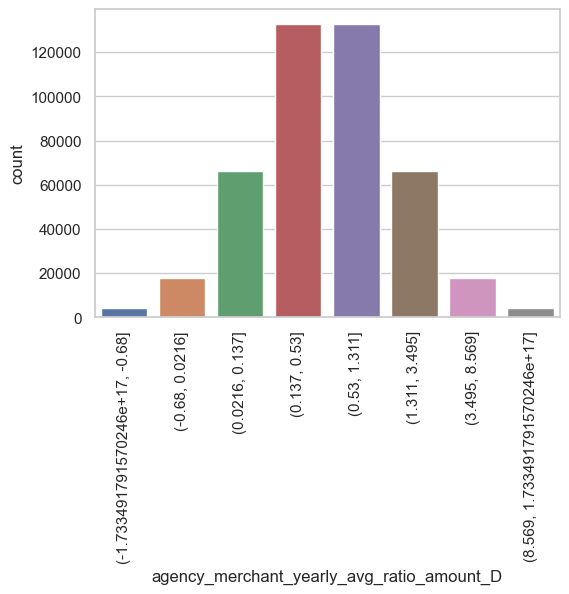

In [138]:
#sns.countplot(x="agency_merchant_yearly_avg_ratio_amount_D", data=df3)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_yearly_avg_ratio_amount_D", data=df5)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [139]:
df5[df5['agency_merchant_yearly_avg_ratio_amount']>2].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,yearly_AVG_amount,agency_merchant_yearly_avg_ratio_amount,agency_merchant_yearly_avg_ratio_amount_D
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,2013,7,31,Tuesday,442.352462,2.011970,"(1.311, 3.495]"
16,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mohiuddin,I,GENERAL PURCHASE,2425.00,WESTERN EQUIPMENT ALVA,2013-07-29,2013-07-31,HARDWARE STORES,2013,7,31,Monday,174.546405,13.893154,"(8.569, 1.733491791570246e+17]"
17,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mohiuddin,I,GENERAL PURCHASE,2425.00,WESTERN EQUIPMENT ALVA,2013-07-29,2013-07-31,HARDWARE STORES,2013,7,31,Monday,174.546405,13.893154,"(8.569, 1.733491791570246e+17]"
33,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Gerlt,T,GENERAL PURCHASE,3582.00,TELVENT,2013-07-26,2013-07-29,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,2013,7,30,Friday,424.422218,8.439709,"(3.495, 8.569]"
35,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,GODSEY,R,GENERAL PURCHASE,407.85,OPTIMUM ENERGY PROD,2013-07-26,2013-07-29,HARDWARE STORES,2013,7,30,Friday,174.546405,2.336628,"(1.311, 3.495]"


### 3.6 Feature 6: The ratio to the yearly median amount

1. From previous features we chose, we formulated structures based on agency,merchant, and year category
2. Furthermore, we can dive deeper in the same structure but more detailed in yearly-time dimension by looking into variable year

In [140]:
# create median spending group by agency, merchant and month category 
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category', 'Year'])['Amount'].median() 
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['yearly_Median_amount']

In [141]:
# add the new feature average spending to the dataset 
df6 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category', 'Year'])
# Feature 6: ratio of amount spending and median spending by merchant category on years
df6['agency_merchant_yearly_median_ratio_amount'] = np.where(df6['yearly_Median_amount']==0,0, df6['Amount'] / df6['yearly_Median_amount'])
#df6['agency_merchant_yearly_median_ratio_amount'].describe()

In [142]:
# cut by percentile for plotting
var = 'agency_merchant_yearly_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df6[binned_var] = pd.qcut(df6[var],percentile)
df6[['agency_merchant_yearly_median_ratio_amount_D']]

,agency_merchant_yearly_median_ratio_amount_D
0,"(2.649, 9.214]"
1,"(1.0, 2.649]"
2,"(0.366, 1.0]"
3,"(2.649, 9.214]"
4,"(1.0, 2.649]"
...,...
442453,"(1.0, 2.649]"
442454,"(2.649, 9.214]"
442455,"(0.366, 1.0]"
442456,"(27.893, 533293.661]"


[Text(0, 0, '(-102375.001, -1.116]'),
 Text(1, 0, '(-1.116, 0.0655]'),
 Text(2, 0, '(0.0655, 0.366]'),
 Text(3, 0, '(0.366, 1.0]'),
 Text(4, 0, '(1.0, 2.649]'),
 Text(5, 0, '(2.649, 9.214]'),
 Text(6, 0, '(9.214, 27.893]'),
 Text(7, 0, '(27.893, 533293.661]')]

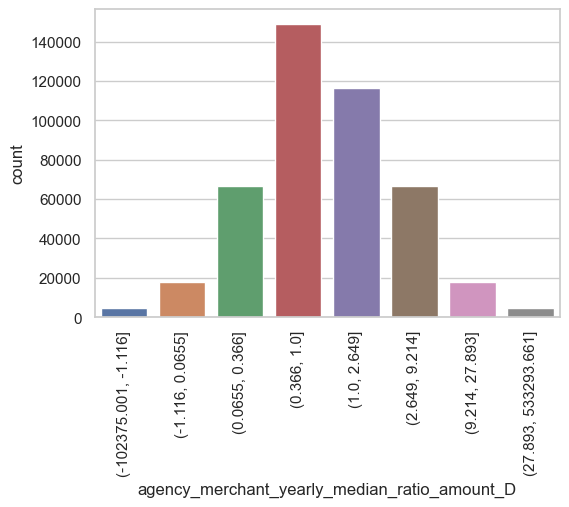

In [143]:
#sns.countplot(x="agency_merchant_yearly_median_ratio_amount_D", data=df6)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_yearly_median_ratio_amount_D", data=df6)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [144]:
df6[df6['agency_merchant_yearly_median_ratio_amount']>2].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,yearly_Median_amount,agency_merchant_yearly_median_ratio_amount,agency_merchant_yearly_median_ratio_amount_D
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,2013,7,31,Tuesday,250.000,3.560000,"(2.649, 9.214]"
3,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS",2013,7,31,Tuesday,32.970,2.923567,"(2.649, 9.214]"
5,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,GENERAL PURCHASE,394.28,KYOCERA DOCUMENT SOLUTION,2013-07-29,2013-07-31,"OFFICE, PHOTOGRAPHIC, PHOTOCOPY, AND MICROFILM...",2013,7,31,Monday,179.200,2.200223,"(1.0, 2.649]"
12,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,McLemore,A,GENERAL PURCHASE,572.27,GIDDINGS MACHINE CO.,2013-07-30,2013-07-31,"COMMERCIAL EQUIPMENT, NOT ELSEWHERE CLASSIFIED",2013,7,31,Tuesday,181.925,3.145637,"(2.649, 9.214]"
14,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Meints,K,GENERAL PURCHASE,445.00,OK DEPT OF VO-TECH ED,2013-07-30,2013-07-31,GOVERNMENT SERVICES--NOT ELSEWHERE CLASSIFIED,2013,7,31,Tuesday,76.000,5.855263,"(2.649, 9.214]"


### 3.7 Feature 7: Average amount spent in Day of week

1. This feature can tell us the expense pattern on days in daily basis
2. For example, weekends usually spend more and weekdays usually spend less

In [145]:
df['Day_of_Week'].value_counts()

Wednesday    89644
Thursday     87537
Tuesday      86919
Friday       79917
Monday       61809
Saturday     26307
Sunday       10325
Name: Day_of_Week, dtype: int64

In [146]:
# create average spending group by agency and merchant category 
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category', 'Day_of_Week'])['Amount'].mean()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['dow_AVG_amount']
stat_by_agency

dow_AVG_amount
Agency_Name                     Merchant_Category                          Day_of_Week                
ARDMORE HIGHER EDUCATION CENTER BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED Friday           115.120000
                                CATALOG MERCHANTS                          Friday            31.330000
                                                                           Monday           334.540000
                                                                           Thursday        -269.590000
                                                                           Wednesday         38.160000
...                                                                                                ...
`DEPARTMENT OF EDUCATION        UNITED AIRLINES                            Thursday         331.466667
                                                                           Tuesday         -283.500000
                                                                           Wednesday        352.800000
                                WYNDHAM HOTELS                             Thursday          87.000000
                                                                           Tuesday          101.660000

[27574 rows x 1 columns]

In [147]:
# add the new feature average spending to the dataset 
df7 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category', 'Day_of_Week'])
# Feature 1: ratio of amount spending and avergae spending by merchant category 
df7['agency_merchant_dow_avg_ratio_amount'] = np.where(df7['dow_AVG_amount']==0,0, df7['Amount'] / df7['dow_AVG_amount'])
df7['agency_merchant_dow_avg_ratio_amount'].describe()

count    4.424580e+05
mean     9.958816e-01
std      3.091416e+15
min     -5.875565e+17
25%      1.938586e-01
50%      5.725592e-01
75%      1.115607e+00
max      5.875565e+17
Name: agency_merchant_dow_avg_ratio_amount, dtype: float64

In [148]:
# cut by percentile for plotting
var = 'agency_merchant_dow_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df7[binned_var] = pd.qcut(df7[var],percentile)
df7[['agency_merchant_dow_avg_ratio_amount_D']]

,agency_merchant_dow_avg_ratio_amount_D
0,"(1.317, 3.454]"
1,"(0.573, 1.317]"
2,"(0.146, 0.573]"
3,"(1.317, 3.454]"
4,"(0.146, 0.573]"
...,...
442453,"(1.317, 3.454]"
442454,"(0.573, 1.317]"
442455,"(0.0233, 0.146]"
442456,"(8.378, 5.875564958853576e+17]"


[Text(0, 0, '(-5.875564958853576e+17, -0.746]'),
 Text(1, 0, '(-0.746, 0.0233]'),
 Text(2, 0, '(0.0233, 0.146]'),
 Text(3, 0, '(0.146, 0.573]'),
 Text(4, 0, '(0.573, 1.317]'),
 Text(5, 0, '(1.317, 3.454]'),
 Text(6, 0, '(3.454, 8.378]'),
 Text(7, 0, '(8.378, 5.875564958853576e+17]')]

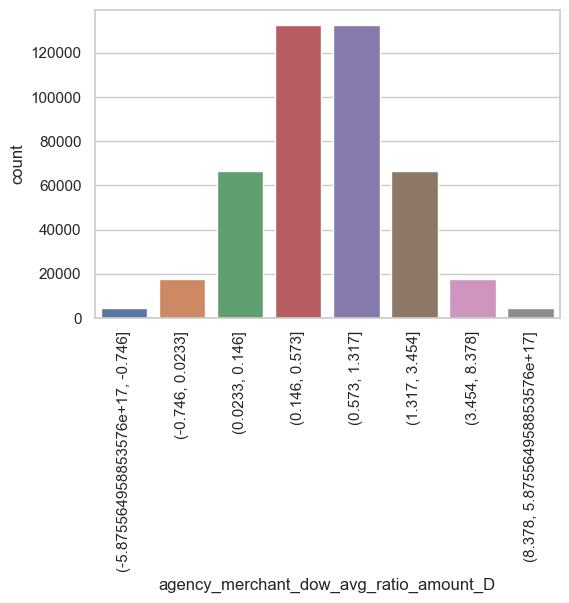

In [149]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_dow_avg_ratio_amount_D", data=df7)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [150]:
df7[df7['agency_merchant_dow_avg_ratio_amount']>2].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,dow_AVG_amount,agency_merchant_dow_avg_ratio_amount,agency_merchant_dow_avg_ratio_amount_D
16,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mohiuddin,I,GENERAL PURCHASE,2425.0,WESTERN EQUIPMENT ALVA,2013-07-29,2013-07-31,HARDWARE STORES,2013,7,31,Monday,164.736967,14.720436,"(8.378, 5.875564958853576e+17]"
17,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mohiuddin,I,GENERAL PURCHASE,2425.0,WESTERN EQUIPMENT ALVA,2013-07-29,2013-07-31,HARDWARE STORES,2013,7,31,Monday,164.736967,14.720436,"(8.378, 5.875564958853576e+17]"
33,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Gerlt,T,GENERAL PURCHASE,3582.0,TELVENT,2013-07-26,2013-07-29,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,2013,7,30,Friday,430.365481,8.323158,"(3.454, 8.378]"
47,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,DALCOUR,K,GENERAL PURCHASE,1312.2,NATURAL WATER COMPANY LLC,2013-07-24,2013-07-26,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,2013,7,30,Wednesday,423.237493,3.100387,"(1.317, 3.454]"
49,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,DALCOUR,K,GENERAL PURCHASE,914.0,AUTO-CHLOR SERVICES INC,2013-07-24,2013-07-26,CATALOG MERCHANTS,2013,7,30,Wednesday,431.513194,2.118128,"(1.317, 3.454]"


### 3.8 Feature 8: total amount spent in Day of week

This feature can tell us the expense pattern on days in weekly basis

In [151]:
# create total spending group by agency and merchant category in wod basis
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category', 'Day_of_Week'])['Amount'].sum()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['dow_sum_amount']
stat_by_agency

dow_sum_amount
Agency_Name                     Merchant_Category                          Day_of_Week                
ARDMORE HIGHER EDUCATION CENTER BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED Friday               115.12
                                CATALOG MERCHANTS                          Friday                62.66
                                                                           Monday               334.54
                                                                           Thursday            -808.77
                                                                           Wednesday             38.16
...                                                                                                ...
`DEPARTMENT OF EDUCATION        UNITED AIRLINES                            Thursday             994.40
                                                                           Tuesday            -1134.00
                                                                           Wednesday           2822.40
                                WYNDHAM HOTELS                             Thursday             348.00
                                                                           Tuesday              304.98

[27574 rows x 1 columns]

In [152]:
# add the new feature total spending to the dataset 
df8 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category', 'Day_of_Week'])
# Feature 1: ratio of amount spending and total spending by merchant category and dow
df8['agency_merchant_dow_sum_ratio_amount'] = np.where(df8['dow_sum_amount']==0,0, df8['Amount'] / df8['dow_sum_amount'])
df8['agency_merchant_dow_sum_ratio_amount'].describe()

count    4.424580e+05
mean     6.193411e-02
std      5.761521e+13
min     -1.013028e+16
25%      7.193788e-04
50%      3.281183e-03
75%      2.394413e-02
max      1.013028e+16
Name: agency_merchant_dow_sum_ratio_amount, dtype: float64

In [153]:
# cut by percentile for plotting
var = 'agency_merchant_dow_sum_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df8[binned_var] = pd.qcut(df8[var],percentile)
df8[['agency_merchant_dow_sum_ratio_amount_D']]

,agency_merchant_dow_sum_ratio_amount_D
0,"(0.00328, 0.0393]"
1,"(0.00328, 0.0393]"
2,"(0.000511, 0.00328]"
3,"(0.000511, 0.00328]"
4,"(0.000511, 0.00328]"
...,...
442453,"(0.0393, 0.392]"
442454,"(0.00328, 0.0393]"
442455,"(0.000511, 0.00328]"
442456,"(0.392, 1.0]"


[Text(0, 0, '(-1.013028441181651e+16, -0.0102]'),
 Text(1, 0, '(-0.0102, 6.48e-05]'),
 Text(2, 0, '(6.48e-05, 0.000511]'),
 Text(3, 0, '(0.000511, 0.00328]'),
 Text(4, 0, '(0.00328, 0.0393]'),
 Text(5, 0, '(0.0393, 0.392]'),
 Text(6, 0, '(0.392, 1.0]'),
 Text(7, 0, '(1.0, 1.013028441181651e+16]')]

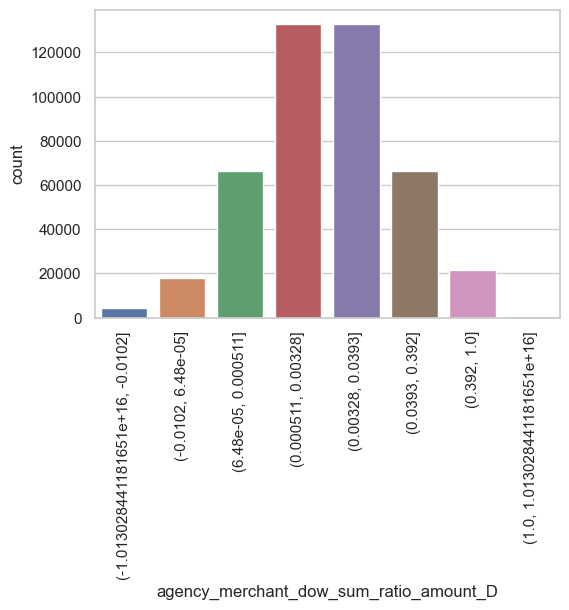

In [154]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_dow_sum_ratio_amount_D", data=df8)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [155]:
df8[df8['agency_merchant_dow_sum_ratio_amount']>2].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,dow_sum_amount,agency_merchant_dow_sum_ratio_amount,agency_merchant_dow_sum_ratio_amount_D
8166,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Oliver,S,GENERAL PURCHASE,-319.3,CLAIM ADJ/BED BATH & BEYO,2013-07-09,2013-07-23,MISCELLANEOUS HOME FURNISHING SPECIALTY STORES,2013,7,28,Tuesday,-13.25,24.098113,"(1.0, 1.013028441181651e+16]"
8572,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Traynor,M,GENERAL PURCHASE,-270.0,ALASKA RAILROAD,2013-07-22,2013-07-23,"LOCAL AND SUBURBAN COMMUTER PASS TRANS, INCLUD...",2013,7,30,Monday,-125.19,2.156722,"(1.0, 1.013028441181651e+16]"
15467,2013-08-01,1000,OKLAHOMA STATE UNIVERSITY,Davis,C,GENERAL PURCHASE,4999.0,YAMAHA OF STILLWATER,2013-08-02,2013-08-05,MOTORCYCLE DEALERS,2013,8,31,Friday,1173.11,4.261322,"(1.0, 1.013028441181651e+16]"
15607,2013-08-01,1000,OKLAHOMA STATE UNIVERSITY,Elmore,D,GENERAL PURCHASE,4999.0,YAMAHA OF STILLWATER,2013-08-02,2013-08-05,MOTORCYCLE DEALERS,2013,8,31,Friday,1173.11,4.261322,"(1.0, 1.013028441181651e+16]"
29001,2013-09-01,1000,OKLAHOMA STATE UNIVERSITY,Worley,G,GENERAL PURCHASE,34.0,STEPHANIE KENDRICK DDS,2013-09-23,2013-09-24,DENTISTS AND ORTHODONTISTS,2013,9,39,Monday,6.00,5.666667,"(1.0, 1.013028441181651e+16]"


### 3.9 Feature 9: The ratio to the average amount by vendors

1. This feature can tell us the average expense on agency name, merchant category by each vedor

In [157]:
# create average spending group by agency, merchant category and vendor
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category', 'Vendor'])['Amount'].mean()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['vendor_avg_amount']
stat_by_agency

vendor_avg_amount
Agency_Name                     Merchant_Category                          Vendor                                      
ARDMORE HIGHER EDUCATION CENTER BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED PITNEY BOWES                      115.120000
                                CATALOG MERCHANTS                          CDW GOVERNMENT                    -53.344286
                                COMPUTER NETWORK/INFORMATION SERVICES      GODADDY.COM                        18.340000
                                DRUG STORES AND PHARMACIES                 WALGREENS #5739                   153.450000
                                GROCERY STORES,AND SUPERMARKETS            HOMELAND #169                      35.030000
...                                                                                                                 ...
`DEPARTMENT OF EDUCATION        UNITED AIRLINES                            UNITED      0167369143104         181.800000
                                                                           UNITED      0167369143111         181.800000
                                                                           UNITED      0167369143116         197.800000
                                                                           UNITED      0167370238791         272.800000
                                WYNDHAM HOTELS                             WYNDHAM GARDEN HOTEL               93.282857

[112690 rows x 1 columns]

In [158]:
# add the new feature average spending to the dataset 
df9 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category', 'Vendor'])
# Feature 9: ratio of amount spending and avergae spending by vendor
df9['agency_merchant_vendor_avg_ratio_amount'] = np.where(df9['vendor_avg_amount']==0,0, df9['Amount'] / df9['vendor_avg_amount'])
df9['agency_merchant_vendor_avg_ratio_amount'].describe()

count    4.424580e+05
mean     9.656578e-01
std      1.963144e+14
min     -6.944551e+16
25%      3.414728e-01
50%      9.576271e-01
75%      1.038744e+00
max      6.424385e+16
Name: agency_merchant_vendor_avg_ratio_amount, dtype: float64

In [159]:
# cut by percentile for plotting
var = 'agency_merchant_vendor_avg_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df9[binned_var] = pd.qcut(df9[var],percentile)
df9[['agency_merchant_vendor_avg_ratio_amount_D']]

,agency_merchant_vendor_avg_ratio_amount_D
0,"(1.22, 2.788]"
1,"(0.255, 0.958]"
2,"(1.22, 2.788]"
3,"(1.22, 2.788]"
4,"(0.255, 0.958]"
...,...
442453,"(0.04, 0.255]"
442454,"(1.22, 2.788]"
442455,"(1.22, 2.788]"
442456,"(6.116, 6.424384868444013e+16]"


[Text(0, 0, '(-6.944550625405305e+16, -0.507]'),
 Text(1, 0, '(-0.507, 0.04]'),
 Text(2, 0, '(0.04, 0.255]'),
 Text(3, 0, '(0.255, 0.958]'),
 Text(4, 0, '(0.958, 1.22]'),
 Text(5, 0, '(1.22, 2.788]'),
 Text(6, 0, '(2.788, 6.116]'),
 Text(7, 0, '(6.116, 6.424384868444013e+16]')]

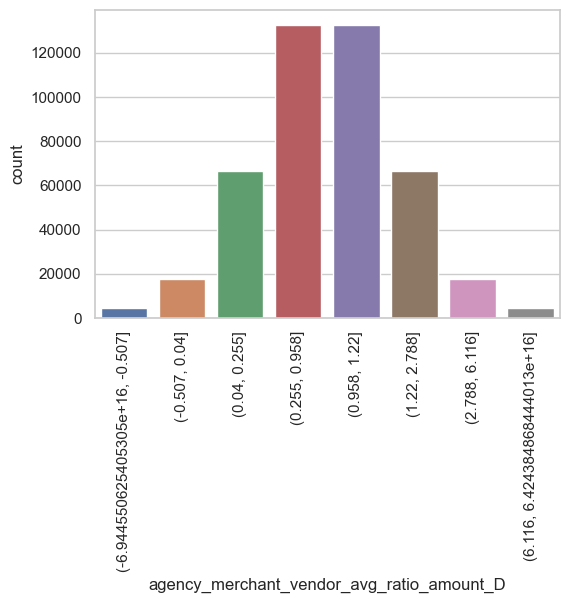

In [160]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_vendor_avg_ratio_amount_D", data=df9)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [161]:
df9[df9['agency_merchant_vendor_avg_ratio_amount']>2].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,vendor_avg_amount,agency_merchant_vendor_avg_ratio_amount,agency_merchant_vendor_avg_ratio_amount_D
8,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,McCarthy,D,GENERAL PURCHASE,142.60,UFIRST LAUNDRY SVCS,2013-07-30,2013-07-31,"MENS, WOMENS AND CHILDRENS UNIFORMS AND COMMER...",2013,7,31,Tuesday,56.362245,2.530062,"(1.22, 2.788]"
47,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,DALCOUR,K,GENERAL PURCHASE,1312.20,NATURAL WATER COMPANY LLC,2013-07-24,2013-07-26,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,2013,7,30,Wednesday,357.718261,3.668250,"(2.788, 6.116]"
50,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Davis,G,Disposable GlovesNitrile EA|Ear Plugs32dBW/o C...,714.94,WW GRAINGER,2013-07-24,2013-07-26,INDUSTRIAL SUPPLIES NOT ELSEWHERE CLASSIFIED,2013,7,30,Wednesday,240.132918,2.977268,"(2.788, 6.116]"
53,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,DAVIS,M,GENERAL PURCHASE,590.40,UNITED REFRIG BR #82,2013-07-25,2013-07-26,"COMMERCIAL EQUIPMENT, NOT ELSEWHERE CLASSIFIED",2013,7,30,Thursday,248.647500,2.374446,"(1.22, 2.788]"
56,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Deaver,G,GENERAL PURCHASE,3835.00,COUNCIL FOR HIGHER EDUC A,2013-07-25,2013-07-26,MEMBERSHIP ORGANIZATIONS--NOT ELSEWHERE CLASSI...,2013,7,30,Thursday,1736.666667,2.208253,"(1.22, 2.788]"


### 3.10 Feature 10: The ratio to the median amount by vendors

1. This feature can tell us the median expense on agency name, merchant category by each vedor

In [162]:
# create average spending group by agency, merchant category and vendor
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category', 'Vendor'])['Amount'].median()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['vendor_median_amount']
stat_by_agency

vendor_median_amount
Agency_Name                     Merchant_Category                          Vendor                                         
ARDMORE HIGHER EDUCATION CENTER BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED PITNEY BOWES                             115.12
                                CATALOG MERCHANTS                          CDW GOVERNMENT                            38.16
                                COMPUTER NETWORK/INFORMATION SERVICES      GODADDY.COM                               18.34
                                DRUG STORES AND PHARMACIES                 WALGREENS #5739                          153.45
                                GROCERY STORES,AND SUPERMARKETS            HOMELAND #169                             35.03
...                                                                                                                    ...
`DEPARTMENT OF EDUCATION        UNITED AIRLINES                            UNITED      0167369143104                181.80
                                                                           UNITED      0167369143111                181.80
                                                                           UNITED      0167369143116                197.80
                                                                           UNITED      0167370238791                272.80
                                WYNDHAM HOTELS                             WYNDHAM GARDEN HOTEL                      87.00

[112690 rows x 1 columns]

In [163]:
# add the new feature average spending to the dataset 
df10 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category', 'Vendor'])
# Feature 10: ratio of amount spending and median spending by merchant category and vendor
df10['agency_merchant_vendor_median_ratio_amount'] = np.where(df10['vendor_median_amount']==0,0, df10['Amount'] / df10['vendor_median_amount'])
df10['agency_merchant_vendor_median_ratio_amount'].describe()

count    442458.000000
mean          1.826771
std          21.214185
min        -683.920000
25%           0.660413
50%           1.000000
75%           1.442708
max       13119.000000
Name: agency_merchant_vendor_median_ratio_amount, dtype: float64

In [164]:
# cut by percentile for plotting
var = 'agency_merchant_vendor_median_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df10[binned_var] = pd.qcut(df10[var],percentile)
df10[['agency_merchant_vendor_median_ratio_amount_D']]

,agency_merchant_vendor_median_ratio_amount_D
0,"(1.0, 1.788]"
1,"(1.788, 5.776]"
2,"(5.776, 16.505]"
3,"(1.788, 5.776]"
4,"(1.0, 1.788]"
...,...
442453,"(0.0912, 0.507]"
442454,"(1.788, 5.776]"
442455,"(1.0, 1.788]"
442456,"(16.505, 13119.0]"


[Text(0, 0, '(-683.9209999999999, -0.995]'),
 Text(1, 0, '(-0.995, 0.0912]'),
 Text(2, 0, '(0.0912, 0.507]'),
 Text(3, 0, '(0.507, 1.0]'),
 Text(4, 0, '(1.0, 1.788]'),
 Text(5, 0, '(1.788, 5.776]'),
 Text(6, 0, '(5.776, 16.505]'),
 Text(7, 0, '(16.505, 13119.0]')]

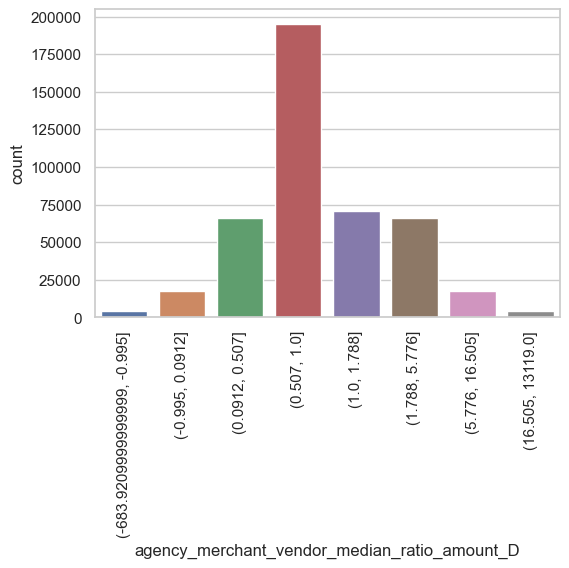

In [165]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_vendor_median_ratio_amount_D", data=df10)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

### 3.11 Feature 11: The ratio to the total amount by vendors

1. This feature can tell us the total expense on agency name, merchant category by each vedor

In [167]:
# create total spending group by agency, merchant category and vendor
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category', 'Vendor'])['Amount'].sum()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['vendor_total_amount']
stat_by_agency

vendor_total_amount
Agency_Name                     Merchant_Category                          Vendor                                        
ARDMORE HIGHER EDUCATION CENTER BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED PITNEY BOWES                            115.12
                                CATALOG MERCHANTS                          CDW GOVERNMENT                         -373.41
                                COMPUTER NETWORK/INFORMATION SERVICES      GODADDY.COM                              18.34
                                DRUG STORES AND PHARMACIES                 WALGREENS #5739                         153.45
                                GROCERY STORES,AND SUPERMARKETS            HOMELAND #169                            35.03
...                                                                                                                   ...
`DEPARTMENT OF EDUCATION        UNITED AIRLINES                            UNITED      0167369143104               181.80
                                                                           UNITED      0167369143111               181.80
                                                                           UNITED      0167369143116               197.80
                                                                           UNITED      0167370238791               272.80
                                WYNDHAM HOTELS                             WYNDHAM GARDEN HOTEL                    652.98

[112690 rows x 1 columns]

In [175]:
# add the new feature total spending to the dataset 
df11 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category', 'Vendor'])
# Feature 10: ratio of amount spending by merchant category and vendor
df11['agency_merchant_vendor_total_ratio_amount'] = np.where(df11['vendor_total_amount']==0,0, df11['Amount'] / df11['vendor_total_amount'])
df11['agency_merchant_vendor_total_ratio_amount'].describe()

count    4.424580e+05
mean     2.472813e-01
std      5.595485e+13
min     -2.314850e+16
25%      1.313042e-03
50%      2.400274e-02
75%      3.406244e-01
max      2.141462e+16
Name: agency_merchant_vendor_total_ratio_amount, dtype: float64

In [178]:
# cut by percentile for plotting
var = 'agency_merchant_vendor_total_ratio_amount'
binned_var = var + '_D'
percentile = [0, 0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99, 1]
df11[binned_var] = pd.qcut(df11[var], percentile, duplicates='drop')
df11[['agency_merchant_vendor_total_ratio_amount_D']]

,agency_merchant_vendor_total_ratio_amount_D
0,"(0.024, 0.674]"
1,"(0.024, 0.674]"
2,"(0.024, 0.674]"
3,"(4.21e-05, 0.000682]"
4,"(0.000682, 0.024]"
...,...
442453,"(0.000682, 0.024]"
442454,"(0.024, 0.674]"
442455,"(0.024, 0.674]"
442456,"(0.674, 1.0]"


[Text(0, 0, '(-2.3148502084684348e+16, -0.0197]'),
 Text(1, 0, '(-0.0197, 4.21e-05]'),
 Text(2, 0, '(4.21e-05, 0.000682]'),
 Text(3, 0, '(0.000682, 0.024]'),
 Text(4, 0, '(0.024, 0.674]'),
 Text(5, 0, '(0.674, 1.0]'),
 Text(6, 0, '(1.0, 2.1414616228146708e+16]')]

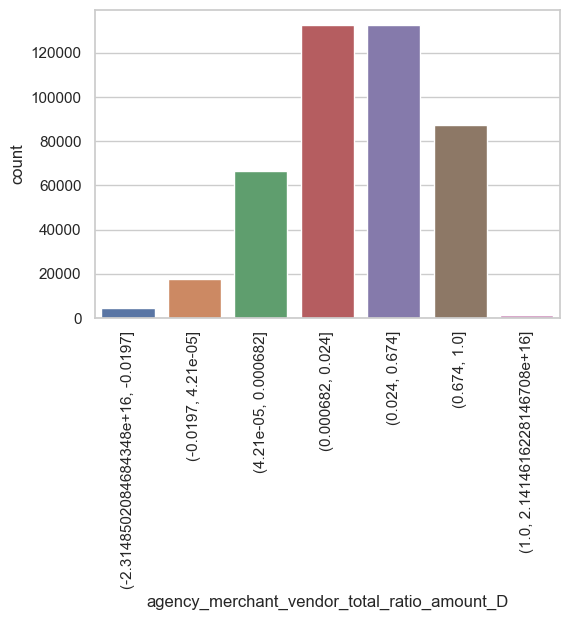

In [179]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_vendor_total_ratio_amount_D", data=df11)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [180]:
df11[df11['agency_merchant_vendor_total_ratio_amount']>2].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,vendor_total_amount,agency_merchant_vendor_total_ratio_amount,agency_merchant_vendor_total_ratio_amount_D
1566,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,DeRaps,M,GENERAL PURCHASE,-215.00,CEDAR CREEK FARMS LLC,2013-06-28,2013-07-02,"LODGING--HOTELS,MOTELS,AND RESORTS",2013,7,26,Friday,-3.500000e+01,6.142857e+00,"(1.0, 2.1414616228146708e+16]"
5105,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,McCabe,S,GENERAL PURCHASE,-239.90,THE ATHERTON HOTL AT OSU,2013-07-11,2013-07-15,"LODGING--HOTELS,MOTELS,AND RESORTS",2013,7,28,Thursday,-7.390000e+01,3.246279e+00,"(1.0, 2.1414616228146708e+16]"
5117,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Clawson,S,GENERAL PURCHASE,220.00,NCHEC INC,2013-07-11,2013-07-12,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,2013,7,28,Thursday,7.975000e+01,2.758621e+00,"(1.0, 2.1414616228146708e+16]"
5132,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Dady,L,GENERAL PURCHASE,11.00,TARGET.COM,2013-07-12,2013-07-12,DISCOUNT STORES,2013,7,28,Friday,4.547474e-13,2.418926e+13,"(1.0, 2.1414616228146708e+16]"
5133,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Dady,L,GENERAL PURCHASE,2382.88,TARGET.COM,2013-07-12,2013-07-12,DISCOUNT STORES,2013,7,28,Friday,4.547474e-13,5.240009e+15,"(1.0, 2.1414616228146708e+16]"


### 3.12 Feature 12: The ratio to the total counts by vendor

1. This feature can tell us the total counts on agency name, merchant category by each vedor

In [87]:
df['Vendor'].value_counts()

STAPLES                      14842
AMAZON MKTPLACE PMTS         12197
WW GRAINGER                  12076
Amazon.com                   10766
BILL WARREN OFFICE PRODUC     4479
                             ...  
AMERICAN AI 0017369561070        1
AMERICAN AI 0017369561061        1
AMERICAN AI 0017369561082        1
UNITED      0167369561044        1
GENERATOR AND MOTOR SERVI        1
Name: Vendor, Length: 86729, dtype: int64

In [181]:
# create total spending group by agency,merchant category and vendor
stat_by_agency = df.groupby(['Agency_Name', 'Merchant_Category', 'Vendor'])['Amount'].count()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['vendor_counts_amount']
stat_by_agency

vendor_counts_amount
Agency_Name                     Merchant_Category                          Vendor                                         
ARDMORE HIGHER EDUCATION CENTER BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED PITNEY BOWES                                  1
                                CATALOG MERCHANTS                          CDW GOVERNMENT                                7
                                COMPUTER NETWORK/INFORMATION SERVICES      GODADDY.COM                                   1
                                DRUG STORES AND PHARMACIES                 WALGREENS #5739                               1
                                GROCERY STORES,AND SUPERMARKETS            HOMELAND #169                                 1
...                                                                                                                    ...
`DEPARTMENT OF EDUCATION        UNITED AIRLINES                            UNITED      0167369143104                     1
                                                                           UNITED      0167369143111                     1
                                                                           UNITED      0167369143116                     1
                                                                           UNITED      0167370238791                     1
                                WYNDHAM HOTELS                             WYNDHAM GARDEN HOTEL                          7

[112690 rows x 1 columns]

In [182]:
# add the new feature counts of spending to the dataset 
df12 = pd.merge(df, stat_by_agency, how='left', on=['Agency_Name', 'Merchant_Category', 'Vendor'])
# Feature 10: ratio of counts of spending by merchant category and vendor
df12['agency_merchant_vendor_counts_ratio_amount'] = np.where(df12['vendor_counts_amount']==0,0, df12['Amount'] / df12['vendor_counts_amount'])
df12['agency_merchant_vendor_counts_ratio_amount'].describe()

count    442458.000000
mean        114.101235
std        2381.254134
min      -11369.333333
25%           0.217901
50%           4.455858
75%          38.779500
max      951929.185000
Name: agency_merchant_vendor_counts_ratio_amount, dtype: float64

In [185]:
# cut by percentile for plotting
var = 'agency_merchant_vendor_counts_ratio_amount'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df12[binned_var] = pd.qcut(df12[var],percentile)
df12[['agency_merchant_vendor_counts_ratio_amount_D']]

,agency_merchant_vendor_counts_ratio_amount_D
0,"(67.674, 508.0]"
1,"(4.456, 67.674]"
2,"(4.456, 67.674]"
3,"(0.00516, 0.107]"
4,"(0.107, 4.456]"
...,...
442453,"(67.674, 508.0]"
442454,"(4.456, 67.674]"
442455,"(4.456, 67.674]"
442456,"(1521.767, 951929.185]"


[Text(0, 0, '(-11369.334, -18.838]'),
 Text(1, 0, '(-18.838, 0.00516]'),
 Text(2, 0, '(0.00516, 0.107]'),
 Text(3, 0, '(0.107, 4.456]'),
 Text(4, 0, '(4.456, 67.674]'),
 Text(5, 0, '(67.674, 508.0]'),
 Text(6, 0, '(508.0, 1521.767]'),
 Text(7, 0, '(1521.767, 951929.185]')]

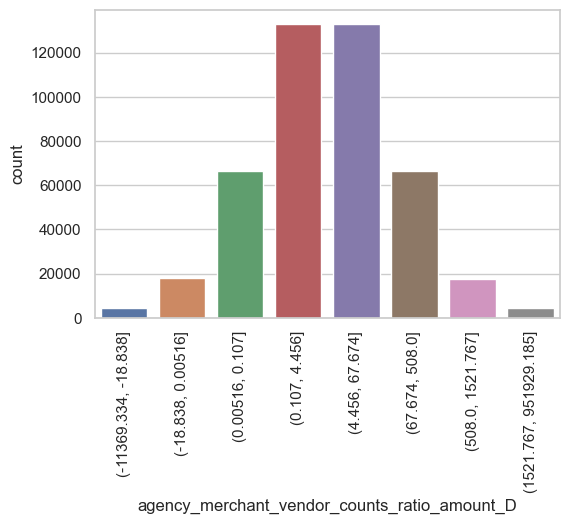

In [186]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="agency_merchant_vendor_counts_ratio_amount_D", data=df12)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [187]:
df12[df12['agency_merchant_vendor_counts_ratio_amount']>2].head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Day_of_Week,vendor_counts_amount,agency_merchant_vendor_counts_ratio_amount,agency_merchant_vendor_counts_ratio_amount_D
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,2013,7,31,Tuesday,9,98.888889,"(67.674, 508.0]"
1,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON,2013,7,31,Tuesday,30,12.298667,"(4.456, 67.674]"
2,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,2013,7,31,Monday,12,13.818333,"(4.456, 67.674]"
5,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,GENERAL PURCHASE,394.28,KYOCERA DOCUMENT SOLUTION,2013-07-29,2013-07-31,"OFFICE, PHOTOGRAPHIC, PHOTOCOPY, AND MICROFILM...",2013,7,31,Monday,8,49.285000,"(4.456, 67.674]"
10,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,McGowin,R,GENERAL PURCHASE,278.23,RANDY'S FOODS,2013-07-29,2013-07-31,FREEZER AND LOCKER MEAT PROVISIONERS,2013,7,31,Monday,57,4.881228,"(4.456, 67.674]"


### 3.13 Feature 13: Transaction frequency in daily basis

1. This feature can show us the transaction frequency in daily basis by agency and merchant category

In [194]:
# Transaction Frequency by Merchant Category
stat_by_agency = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Transaction_Date']).size()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['daily_transaction_frequency']
stat_by_agency

daily_transaction_frequency
Cardholder_Last_Name Cardholder_First_Initial Transaction_Date                             
15000                1                        2014-03-10                                  1
24100                2                        2013-07-15                                  1
                                              2013-07-25                                  1
                                              2013-08-15                                  1
                                              2013-08-26                                  1
...                                                                                     ...
russell              s                        2014-06-24                                  3
                                              2014-06-25                                  5
                                              2014-06-26                                  3
                                              2014-06-27                                  1
                                              2014-06-28                                  2

[226971 rows x 1 columns]

In [195]:
# add the new feature average spending to the dataset 
df13 = pd.merge(df, stat_by_agency, how='left', on=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Transaction_Date'])

# Feature 13: ratio of transaction frequency by merchant category in daily basis
df13['daily_transaction_frequency_ratio'] = np.where(df13['daily_transaction_frequency'].isnull(), 0, df13['Amount'] / df13['daily_transaction_frequency'])

df13['daily_transaction_frequency_ratio'].describe()

count    4.424580e+05
mean     2.113476e+02
std      4.133273e+03
min     -3.850687e+04
25%      1.039000e+01
50%      3.944875e+01
75%      1.362750e+02
max      1.903858e+06
Name: daily_transaction_frequency_ratio, dtype: float64

In [196]:
# cut by percentile for plotting
var = 'daily_transaction_frequency_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df13[binned_var] = pd.qcut(df13[var],percentile)
df13[['daily_transaction_frequency_ratio_D']]

,daily_transaction_frequency_ratio_D
0,"(184.78, 786.21]"
1,"(39.449, 184.78]"
2,"(39.449, 184.78]"
3,"(39.449, 184.78]"
4,"(39.449, 184.78]"
...,...
442453,"(39.449, 184.78]"
442454,"(184.78, 786.21]"
442455,"(7.288, 39.449]"
442456,"(786.21, 2529.678]"


[Text(0, 0, '(-38506.871, -52.38]'),
 Text(1, 0, '(-52.38, 0.541]'),
 Text(2, 0, '(0.541, 7.288]'),
 Text(3, 0, '(7.288, 39.449]'),
 Text(4, 0, '(39.449, 184.78]'),
 Text(5, 0, '(184.78, 786.21]'),
 Text(6, 0, '(786.21, 2529.678]'),
 Text(7, 0, '(2529.678, 1903858.37]')]

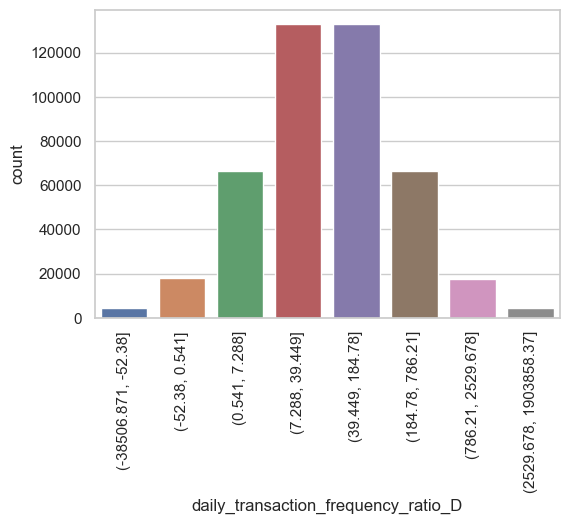

In [197]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="daily_transaction_frequency_ratio_D", data=df13)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

### 3.14 Feature 14: Transaction frequency in yearly basis

1. This feature can show us the transaction frequency in yearly basis by agency and merchant category

In [199]:
# Transaction Frequency by name in yearly basis
stat_by_agency = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Year']).size()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['yearly_transaction_frequency']
stat_by_agency

yearly_transaction_frequency
Cardholder_Last_Name Cardholder_First_Initial Year                              
15000                1                        2014                             1
24100                2                        2013                             7
                                              2014                             3
42000                4                        2013                             5
                                              2014                            11
...                                                                          ...
de Leon              R                        2013                            46
                                              2014                            39
owell                K                        2013                            47
                                              2014                            17
russell              s                        2014                            35

[9334 rows x 1 columns]

In [200]:
# add the new feature transaction frequency to the dataset 
df14 = pd.merge(df, stat_by_agency, how='left', on=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Year'])

# Feature 14: ratio of transaction frequenct by name
df14['yearly_transaction_frequency_ratio'] = np.where(df14['yearly_transaction_frequency'].isnull(), 0, df14['Amount'] / df14['yearly_transaction_frequency'])

df14['yearly_transaction_frequency_ratio'].describe()

count    442458.000000
mean         11.838055
std        1962.608795
min       -1605.384615
25%           0.216450
50%           0.946985
75%           3.626667
max      951929.185000
Name: yearly_transaction_frequency_ratio, dtype: float64

In [201]:
# cut by percentile for plotting
var = 'yearly_transaction_frequency_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df14[binned_var] = pd.qcut(df14[var],percentile)
df14[['yearly_transaction_frequency_ratio_D']]

,yearly_transaction_frequency_ratio_D
0,"(5.023, 25.0]"
1,"(0.947, 5.023]"
2,"(0.947, 5.023]"
3,"(0.947, 5.023]"
4,"(0.947, 5.023]"
...,...
442453,"(0.947, 5.023]"
442454,"(0.947, 5.023]"
442455,"(0.146, 0.947]"
442456,"(25.0, 99.323]"


[Text(0, 0, '(-1605.386, -1.462]'),
 Text(1, 0, '(-1.462, 0.00591]'),
 Text(2, 0, '(0.00591, 0.146]'),
 Text(3, 0, '(0.146, 0.947]'),
 Text(4, 0, '(0.947, 5.023]'),
 Text(5, 0, '(5.023, 25.0]'),
 Text(6, 0, '(25.0, 99.323]'),
 Text(7, 0, '(99.323, 951929.185]')]

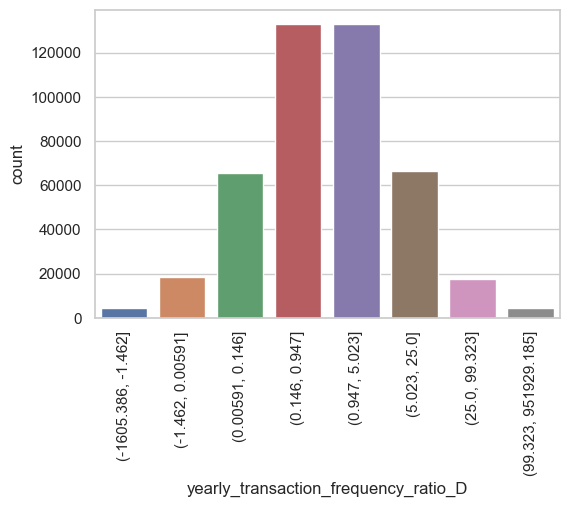

In [202]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="yearly_transaction_frequency_ratio_D", data=df14)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

### 3.15 Feature 15: Transaction frequency in monthly basis

1. This feature can show us the transaction frequency in monthly basis by agency and merchant category

In [204]:
# Transaction Frequency by Merchant Category
stat_by_agency = df.groupby(['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Year', 'Month']).size()
stat_by_agency = pd.DataFrame(stat_by_agency)
stat_by_agency.columns = ['monthly_transaction_frequency']
stat_by_agency

monthly_transaction_frequency
Cardholder_Last_Name Cardholder_First_Initial Year Month                               
15000                1                        2014 4                                  1
24100                2                        2013 7                                  2
                                                   8                                  2
                                                   9                                  1
                                                   12                                 2
...                                                                                 ...
owell                K                        2013 10                                13
                                                   11                                 5
                                                   12                                 8
                                              2014 1                                 17
russell              s                        2014 6                                 35

[42164 rows x 1 columns]

In [205]:
# add the new feature transaction frequency to the dataset 
df15 = pd.merge(df, stat_by_agency, how='left', on=['Cardholder_Last_Name', 'Cardholder_First_Initial', 'Year', 'Month'])

# Feature 15: ratio of transaction frequency by year and month
df15['monthly_transaction_frequency_ratio'] = np.where(df15['monthly_transaction_frequency'].isnull(), 0, df15['Amount'] / df15['monthly_transaction_frequency'])

df15['monthly_transaction_frequency_ratio'].describe()

count    4.424580e+05
mean     4.296572e+01
std      3.910254e+03
min     -8.348000e+03
25%      1.120597e+00
50%      4.805000e+00
75%      1.827856e+01
max      1.903858e+06
Name: monthly_transaction_frequency_ratio, dtype: float64

In [206]:
# cut by percentile for plotting
var = 'monthly_transaction_frequency_ratio'
binned_var = var + '_D'
percentile = [0,0.01,0.05,0.2,0.5,0.8,0.95,0.99,1]
df15[binned_var] = pd.qcut(df15[var],percentile)
df15[['monthly_transaction_frequency_ratio_D']]

,monthly_transaction_frequency_ratio_D
0,"(4.805, 25.345]"
1,"(4.805, 25.345]"
2,"(4.805, 25.345]"
3,"(4.805, 25.345]"
4,"(4.805, 25.345]"
...,...
442453,"(4.805, 25.345]"
442454,"(4.805, 25.345]"
442455,"(0.764, 4.805]"
442456,"(123.773, 467.989]"


[Text(0, 0, '(-8348.001, -6.909]'),
 Text(1, 0, '(-6.909, 0.0339]'),
 Text(2, 0, '(0.0339, 0.764]'),
 Text(3, 0, '(0.764, 4.805]'),
 Text(4, 0, '(4.805, 25.345]'),
 Text(5, 0, '(25.345, 123.773]'),
 Text(6, 0, '(123.773, 467.989]'),
 Text(7, 0, '(467.989, 1903858.37]')]

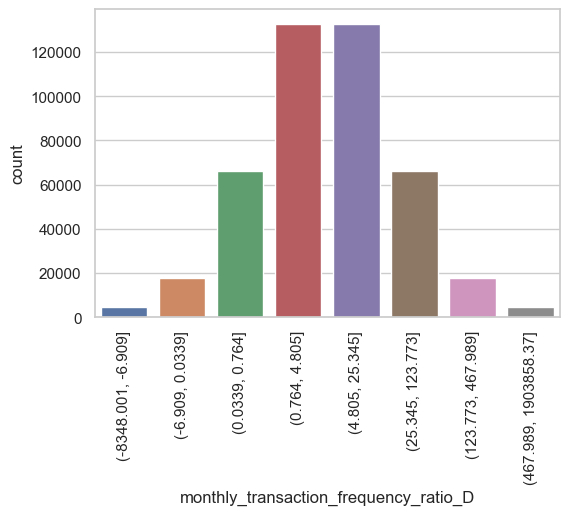

In [207]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
g = sns.countplot(x="monthly_transaction_frequency_ratio_D", data=df15)
g.set_xticklabels(g.get_xticklabels(), rotation=90)